In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout

### DATA Preprocessing

In [3]:
data = pd.read_csv("../STOCK MARKET/AXISBANK.csv")
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11,NaN,NaN,NaN
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11,NaN,NaN,NaN
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11,NaN,NaN,NaN
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11,NaN,NaN,NaN
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

In [5]:
data.isnull().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

In [6]:
data.drop(columns=["Trades",'Deliverable Volume',"%Deliverble"],inplace=True)

In [7]:
data.isnull().sum()

Date          0
Symbol        0
Series        0
Prev Close    0
Open          0
High          0
Low           0
Last          0
Close         0
VWAP          0
Volume        0
Turnover      0
dtype: int64

<Axes: xlabel='Prev Close'>

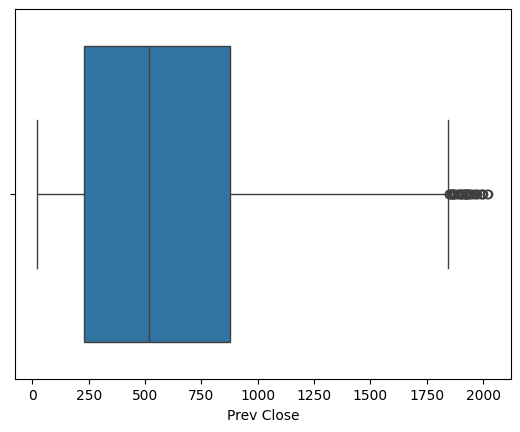

In [8]:
sns.boxplot(x=data['Prev Close'])

<Axes: xlabel='Close'>

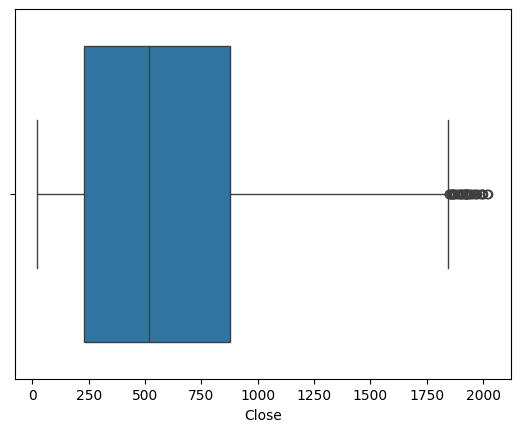

In [9]:
sns.boxplot(x=data['Close'])


In [10]:
q1 = data['Close'].quantile(0.25)
q2 = data['Close'].quantile(0.75)
iqr = q2 - q1
min_range = q1 - (1.5*iqr)
max_range = q2 + (1.5*iqr)
data = data[data['Close']<max_range]
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11


<Axes: xlabel='Close'>

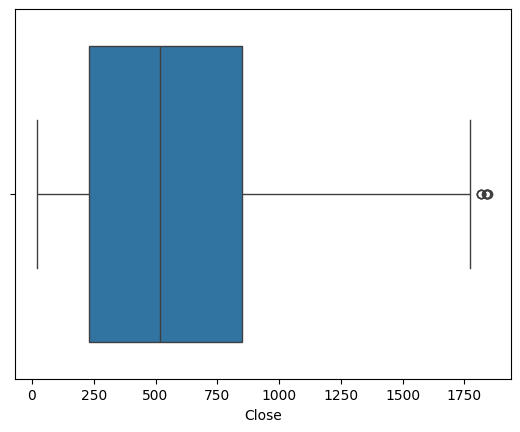

In [11]:
sns.boxplot(x=data['Close'])

In [12]:
data['Date'] = pd.to_datetime(data['Date'])


In [13]:
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11


C:\Users\Asus\AppData\Local\Temp\ipykernel_10356\759272861.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,cmap="Blues")


<Axes: >

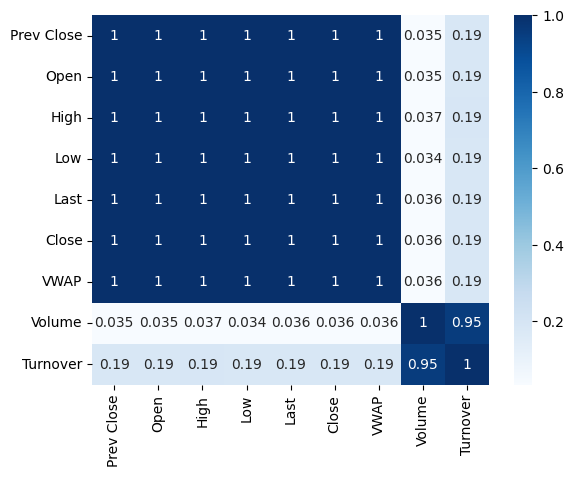

In [14]:
sns.heatmap(data.corr(),annot=True,cmap="Blues")

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


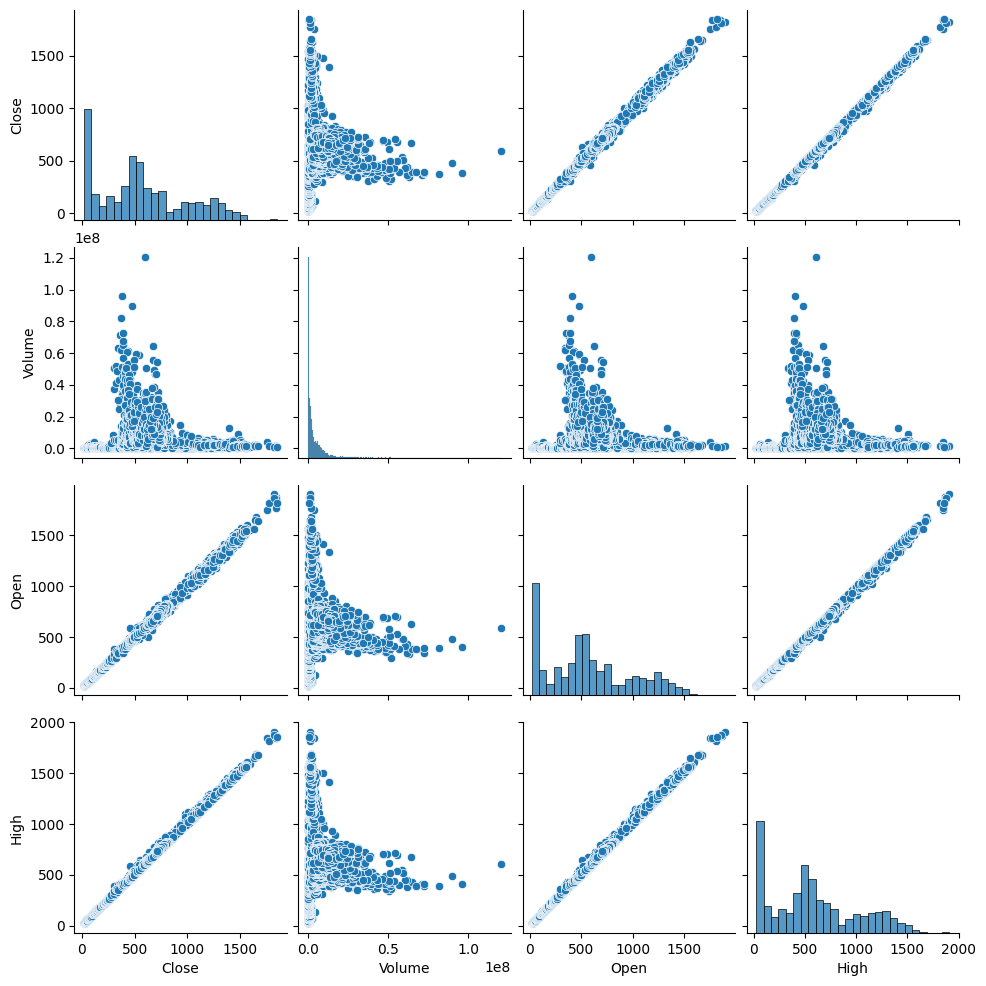

In [15]:
sns.pairplot(data[['Close', 'Volume', 'Open', 'High']])
plt.show()

### Using Linear Regression

In [ ]:
x = data[['Open','High','Low','Prev Close']]  # Last parameter
y = data['Close']

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [148]:
train_size = int(len(data)*0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train, dates_test = data['Date'][:train_size], data['Date'][train_size:]

In [149]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [150]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

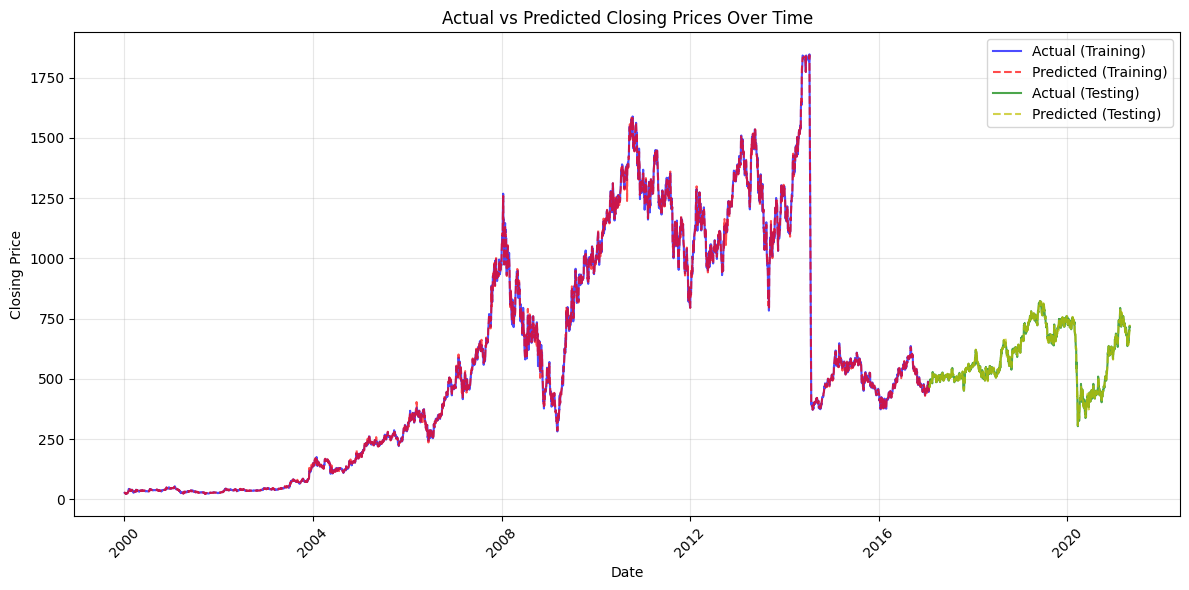

In [151]:
plt.figure(figsize=(12, 6))

plt.plot(dates_train, y_train, 'b', label='Actual (Training)', alpha=0.7)
plt.plot(dates_train, y_pred_train, 'r--', label='Predicted (Training)', alpha=0.7)

plt.plot(dates_test, y_test, 'g-', label='Actual (Testing)', alpha=0.7)
plt.plot(dates_test, y_pred_test, 'y--', label='Predicted (Testing)', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, r2_score
lrmse = mean_squared_error(y_test, y_pred_test)
lrrmse = np.sqrt(lrmse)
lrr2 = r2_score(y_test, y_pred_test)

print("Test Set Performance:")
print(f"Mean Squared Error: {lrmse:.2f}")
print(f"Root Mean Squared Error: {lrrmse:.2f}")
print(f"R-squared Score: {lrr2:.2f}")

Test Set Performance:
Mean Squared Error: 24.70
Root Mean Squared Error: 4.97
R-squared Score: 1.00


In [153]:
dd = {"Actual":y_test,"Predict":y_pred_test}
pd.DataFrame(dd)

,Actual,Predict
4253,472.85,475.497939
4254,471.90,473.934790
4255,466.00,465.517471
4256,475.65,471.356941
4257,482.55,481.239434
...,...,...
5301,700.45,694.012263
5302,699.55,695.340775
5303,708.15,696.311336
5304,719.40,719.361159


In [154]:
dates_train.shape,y_train.shape,y_pred_train.shape

((4212,), (4212,), (4212,))